In [44]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import polars as pl
import polars.selectors as cs
import string
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import utils
path = r'C:\Users\faune\Desktop\thesis\stanford_sentiment.parquet'

## Init

In [ ]:
print('Downloading necessary resources...')
nltk.download('punkt')
nltk.download('stopwords')
df = pd.read_parquet(path)
print('Initialize the stemmer and stop words')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [ ]:
def process_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

## Matching sentences

In [ ]:
df['processed'] = df['sentence'].apply(process_text)

print('Create a vocabulary of all unique words')
vocab = sorted(set(word for tokens in df['processed'].values for word in tokens))

print('One-hot encode the words using MultiLabelBinarizer')
mlb = MultiLabelBinarizer(classes=vocab)


print('Compute quantiles and get the index for the selected quantile')
df['len'] = df['processed'].apply(len)
q=10
df['quantile_len'] = pd.qcut(df['len'],q=q,labels=[f'q{i}' for i in range(1,q+1)])

quantile = 'q10'

df['positive_idx'] = -1
df['negative_idx'] = -1
df.loc[(df.label==0) & (df.quantile_len==quantile),'negative_idx'] = df.loc[(df.label==0) & (df.quantile_len==quantile)].reset_index().index.astype('Int64')
df.loc[(df.label==1) & (df.quantile_len==quantile),'positive_idx'] = df.loc[(df.label==1) & (df.quantile_len==quantile)].reset_index().index.astype('Int64')

print('Compute the gram matrix over the quantile (x positive, y negative)')
X = mlb.fit_transform(df.loc[(df['label']==1) & (df.quantile_len==quantile),'processed'])
Y = mlb.fit_transform(df.loc[(df['label']==0) & (df.quantile_len==quantile),'processed'])
matrix = X@Y.T


print('Merging the output to make the correspondance between positive and neg sentences')
positive_quantile_df = df.loc[(df.label==1) & (df.quantile_len==quantile),:]
negative_quantile_df = df.loc[(df.label==0) & (df.quantile_len==quantile),:]
positive_quantile_df['neg_closest_idx'] = np.argmax(matrix,axis=1)
merged = positive_quantile_df.merge(negative_quantile_df[['negative_idx','sentence','processed']].rename({'sentence':'neg_sentence','processed':'neg_processed'},axis=1),
                            how='left',
                            left_on='neg_closest_idx',
                            right_on='negative_idx')

## Final computations

In [ ]:
merged

In [ ]:
embeddings = pl.read_parquet(path)

In [ ]:
embeddings.columns

In [ ]:
matched_sentences = (
    pl.DataFrame(merged)
    .select('sentence', 'processed', 'neg_sentence', 'neg_processed')
    .join(embeddings, on = 'sentence')
    .drop('idx')
    .join(embeddings.rename({'sentence': 'neg_sentence'}), on = 'neg_sentence', suffix = '_neg')
    .select(pl.exclude('idx', 'label', 'label_neg'))
)

In [ ]:
utils.display_polars(
    matched_sentences
    .unique()
    .with_columns(pl.col('processed').list.set_intersection(pl.col('neg_processed')).alias('matching_words'))
    .with_columns(pl.col('matching_words').list.len().alias('nb'))
    .with_columns(
            pl.col('nb').truediv(pl.col('processed').list.len()).alias('ratio_pos'), 
            pl.col('nb').truediv(pl.col('neg_processed').list.len()).alias('ratio_neg')
    )
    .with_columns(
        pl.mean_horizontal('ratio_pos', 'ratio_neg').alias('ratio')
    )
    .sort('ratio', descending=True)
    .filter(pl.col('ratio').gt(0.2), pl.col('ratio').lt(0.8))
)

In [40]:
matched_sentences

sentence,processed,neg_sentence,neg_processed,embeddings,embeddings_neg
str,list[str],str,list[str],list[f64],list[f64]
"""i have always …","[""i"", ""have"", … ""that""]","""the entire poi…","[""the"", ""entir"", … ""sens""]","[-0.02655, 0.022507, … 0.019058]","[-0.02951, -0.013542, … -0.025604]"
"""while centered…","[""while"", ""center"", … ""israel""]","""the entire poi…","[""the"", ""entir"", … ""sens""]","[-0.026337, 0.009979, … 0.015419]","[-0.02951, -0.013542, … -0.025604]"
"""though its sto…","[""though"", ""it"", … ""lookse""]","""the entire poi…","[""the"", ""entir"", … ""sens""]","[-0.037903, 0.026352, … 0.030838]","[-0.02951, -0.013542, … -0.025604]"
"""i have always …","[""i"", ""have"", … ""that""]","""the entire poi…","[""the"", ""entir"", … ""sens""]","[-0.028595, 0.026749, … 0.013939]","[-0.02951, -0.013542, … -0.025604]"
""", this marvelo…","[""thi"", ""marvel"", … ""israel""]","""the entire poi…","[""the"", ""entir"", … ""sens""]","[-0.014496, -0.003305, … 0.010147]","[-0.02951, -0.013542, … -0.025604]"
…,…,…,…,…,…
"""talk to her is…","[""talk"", ""to"", … ""watch""]","""fails in makin…","[""fail"", ""in"", … ""care""]","[-0.010658, 0.021744, … -0.001521]","[-0.012512, 0.027496, … 0.00573]"
"""the evocative …","[""the"", ""evoc"", … ""gear""]","""fails in makin…","[""fail"", ""in"", … ""care""]","[-0.034424, 0.029541, … 0.010101]","[-0.012512, 0.027496, … 0.00573]"
"""the evocative …","[""the"", ""evoc"", … ""gear""]","""fails in makin…","[""fail"", ""in"", … ""care""]","[-0.030655, 0.033325, … 0.010094]","[-0.012512, 0.027496, … 0.00573]"


In [55]:
with_metrics = (matched_sentences.unique().with_columns(
        matched_sentences.with_columns(pl.col('embeddings').list.to_array(1024),pl.col('embeddings_neg').list.to_array(1024))
        .map_rows(function=lambda t : tuple(cosine_similarity(X=np.array(t[4]).reshape(1, -1), Y=np.array(t[5]).reshape(1, -1)).tolist()))
    )
    .explode('column_0')
    .sort('column_0')
    .rename({'column_0': 'cosine_similarity'})
    .with_columns(
        matched_sentences.with_columns(pl.col('embeddings').list.to_array(1024),pl.col('embeddings_neg').list.to_array(1024))
        .map_rows(function=lambda t :np.dot(a=t[4], b=np.transpose(t[5])))
    )
    .rename({'map': 'dot_product'})
    .sort('cosine_similarity')
    .with_columns(
        matched_sentences.with_columns(pl.col('embeddings').list.to_array(1024),pl.col('embeddings_neg').list.to_array(1024))
        .map_rows(function=lambda t : tuple(euclidean_distances(X=np.array(t[4]).reshape(1, -1), Y=np.array(t[5]).reshape(1, -1)).tolist()))
    )
    .explode('column_0')
    .rename({'column_0':'euclidean_distance'})
    .with_columns(
        matched_sentences.with_columns(pl.col('embeddings').list.to_array(1024),pl.col('embeddings_neg').list.to_array(1024))
        .map_rows(function=lambda t :np.linalg.norm(x=t[4]) -np.linalg.norm(x=t[5]))
    )
    .rename({'map':'norm_difference'})
)


In [56]:
with_metrics

sentence,processed,neg_sentence,neg_processed,embeddings,embeddings_neg,cosine_similarity,dot_product,euclidean_distance,norm_difference
str,list[str],str,list[str],list[f64],list[f64],f64,f64,f64,f64
"""here relies le…","[""here"", ""reli"", … ""hellsteniu""]","""instead of a w…","[""instead"", ""of"", … ""video""]","[-0.031982, 0.037628, … 0.01078]","[-0.018143, 0.012184, … -0.00366]",0.665127,0.750734,0.705759,-0.000583
"""it 's a perfec…","[""it"", ""s"", … ""it""]","""such a bad mov…","[""such"", ""a"", … ""show""]","[-0.035034, -0.001105, … 0.019608]","[-0.001801, 0.011826, … -0.000638]",0.665864,0.71996,0.748611,-0.000196
"""austin powers …","[""austin"", ""power"", … ""end""]","""with mcconaugh…","[""with"", ""mcconaughey"", … ""crowd""]","[-0.030319, -0.000034, … 0.030655]","[-0.004093, 0.017471, … 0.028275]",0.671825,0.749367,0.708617,0.000071
"""there is a cer…","[""there"", ""is"", … ""compel""]","""to the filmmak…","[""to"", ""the"", … ""merit""]","[-0.039215, 0.026764, … 0.02652]","[-0.064209, 0.041321, … 0.012695]",0.672149,0.734155,0.729625,-0.000034
"""worth a look f…","[""worth"", ""a"", … ""birmingham""]","""goldmember has…","[""goldmemb"", ""ha"", … ""taxicab""]","[-0.042999, 0.017746, … 0.022537]","[-0.027161, 0.012825, … -0.012032]",0.673492,0.729886,0.735338,-0.000118
…,…,…,…,…,…,…,…,…,…
"""that the direc…","[""that"", ""the"", … ""wallop""]","""as gamely as t…","[""as"", ""game"", … ""bridg""]","[-0.033203, 0.006603, … -0.000787]","[-0.022034, 0.034271, … -0.029648]",0.998046,0.850958,0.54558,0.000369
"""frequent flurr…","[""frequent"", ""flurri"", … ""eas""]","""of day by conc…","[""of"", ""day"", … ""retali""]","[-0.045013, 0.010361, … 0.025284]","[-0.028503, 0.028809, … -0.044922]",0.998227,0.812926,0.611071,0.000212
"""until it goes …","[""until"", ""it"", … ""film""]","""mib ii is a mo…","[""mib"", ""ii"", … ""anyth""]","[-0.044281, 0.015099, … -0.008934]","[-0.019867, 0.044312, … -0.008751]",0.998512,0.802118,0.628761,0.000371


<Axes: xlabel='euclidean_distance', ylabel='Count'>

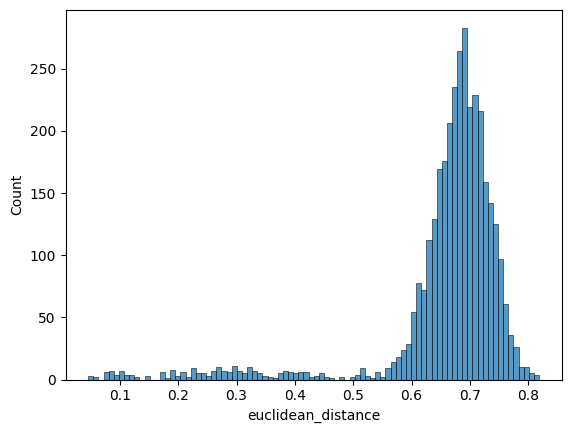

In [49]:
import seaborn as sns 

sns.histplot(data=with_metrics.to_pandas(), x='euclidean_distance')

<Axes: xlabel='cosine_similarity', ylabel='Count'>

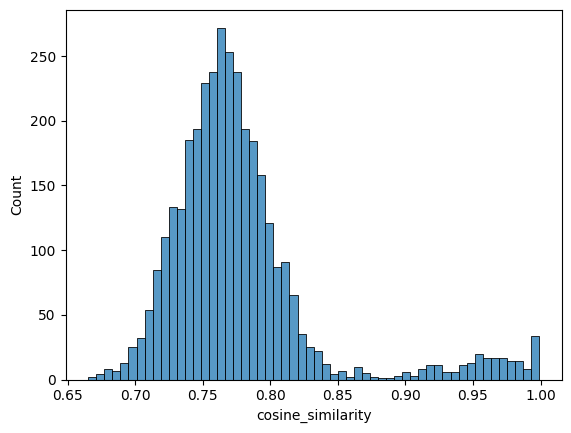

In [50]:
sns.histplot(data=with_metrics.to_pandas(), x='cosine_similarity')

<Axes: xlabel='dot_product', ylabel='Count'>

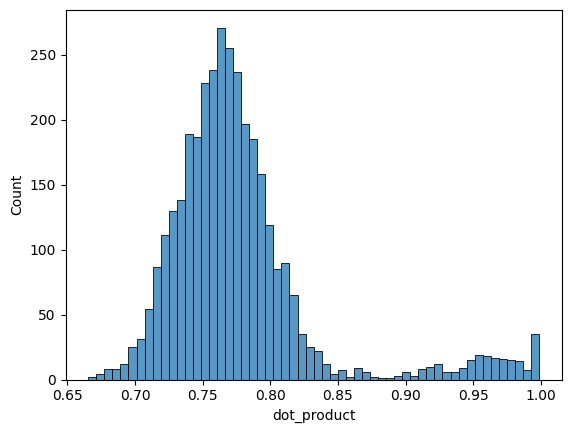

In [51]:
sns.histplot(data=with_metrics.to_pandas(), x='dot_product')

<Axes: xlabel='norm_difference', ylabel='Count'>

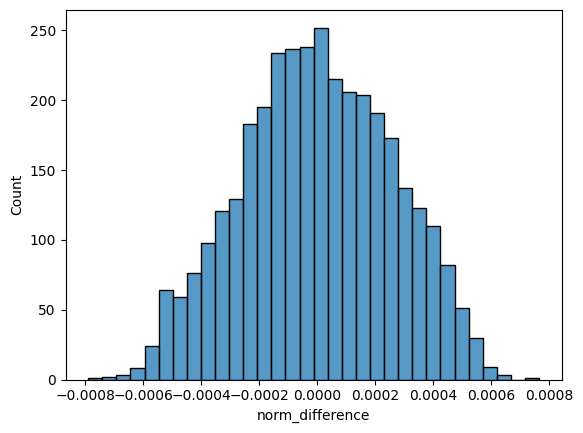

In [57]:
sns.histplot(data=with_metrics.to_pandas(), x='norm_difference')